In [1]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185319 sha256=7329eb4c65fdca4be413659f49bcc5e25b8d824342a49b8bd0b9049b1578d4e7
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [156]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import imageio
import os

from scipy.signal import convolve2d
from mpi4py import MPI
from google.colab import files
from tqdm import tqdm

# 1. Implement Game of Live Functions

In [98]:
def step_game(world_last, kernel):
    world_updated = world_last.copy()

    # add neighbors from other parts of the world
    world_updated = np.pad(world_updated, 1, 'wrap')

    # count alive neighbours
    world_updated = convolve2d(world_updated, kernel, mode='valid')

    # apply cell evolution rules
    world_updated = np.where((world_updated == 3) | ((world_updated == 2) & (world_last == 1)), 1., 0.)
    
    return world_updated

def propagate_game(world_last, n_steps=100):
    kernel = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ]).astype(np.float32)
    
    world_history = [world_last]
    alive_history = [np.sum(world_last)]
    
    for i in range(n_steps):
        world_last = step_game(world_last, kernel)

        world_history.append(world_last)
        alive_history.append(np.sum(world_last))
    
    return world_history, alive_history

# 2. Define Initial States

In [99]:
def plot_world_init(world_init):
    plt.figure(figsize=(10, 10))
    plt.imshow(world_init, cmap=cm.binary_r)

    plt.axis('off')
    plt.show()

### Gosper's Glider Gun

In [146]:
gosper_init_txt = """........................X...........................................................................
......................X.X...........................................................................
............XX......XX............XX................................................................
...........X...X....XX............XX................................................................
XX........X.....X...XX..............................................................................
XX........X...X.XX....X.X...........................................................................
..........X.....X.......X...........................................................................
...........X...X....................................................................................
............XX......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................................................."""

gosper_init_txt = gosper_init_txt.replace('.', '0').replace('X', '1')
gosper_init = np.array([list(row) for row in gosper_init_txt.split('\n')]).astype(np.float32)

In [147]:
gosper_init.shape

(32, 100)

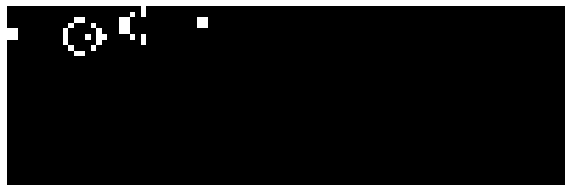

In [148]:
plot_world_init(gosper_init)

### Pulsar

In [133]:
pulsar_init = np.zeros((17, 17))

pulsar_init[2, 4:7] = 1
pulsar_init[4:7, 7] = 1

pulsar_init += pulsar_init.T
pulsar_init += pulsar_init[:, ::-1]
pulsar_init += pulsar_init[::-1, :]

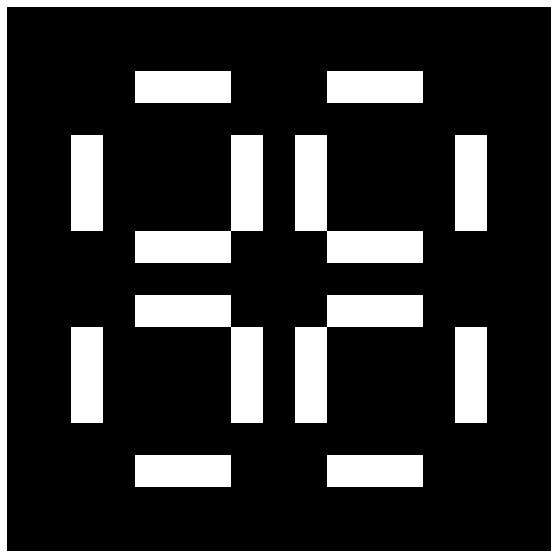

In [134]:
plot_world_init(pulsar_init)

### Random Sparse

In [135]:
from scipy.sparse import rand

In [136]:
random_init = rand(64, 64, density=0.2, format='csr')
random_init.data[:] = 1

random_init = random_init.todense()

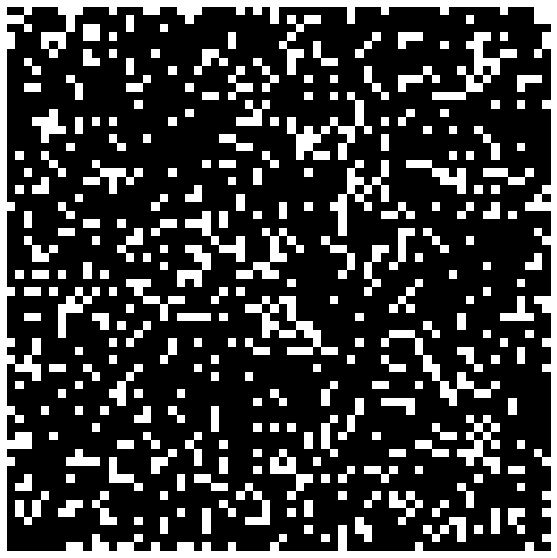

In [137]:
plot_world_init(random_init)

# 3. Perform Simulation

In [170]:
def do_staff(world_init, game_name, n_steps=100, save_gif=False):
    world_history, alive_history = propagate_game(world_init, n_steps)

    if save_gif:
        folder = f'./game-{game_name}/'
        if not os.path.exists(folder):
            os.mkdir(folder)

        for i in tqdm(range(len(world_history))):
            plt.figure(figsize=(10, 10))
            plt.imshow(world_history[i], cmap=cm.binary_r)

            plt.axis('off')
            plt.savefig(folder + f'step-{i}.jpg', bbox_inches='tight')
            plt.close('all')

        filenames = list(filename for filename in os.listdir(folder) if filename.endswith('jpg'))
        filenames = sorted(filenames, key=lambda x: int(os.path.splitext(x)[0].split('-')[-1]))

        images = []
        for i, filename in enumerate(filenames):
            images.append(imageio.imread(folder + filename))

        imageio.mimsave(folder + f'game-{game_name}.gif', images)
        files.download(folder + f'game-{game_name}.gif')

    fig = plt.figure(figsize=(14, 10))
    plt.plot(np.arange(1, len(alive_history) + 1), alive_history)

    plt.xlabel('iteration', fontsize=14)
    plt.ylabel('number of alive cells', fontsize=14)

    plt.grid()
    plt.show()

### Gosper's Glider Gun

100%|██████████| 101/101 [00:06<00:00, 16.43it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

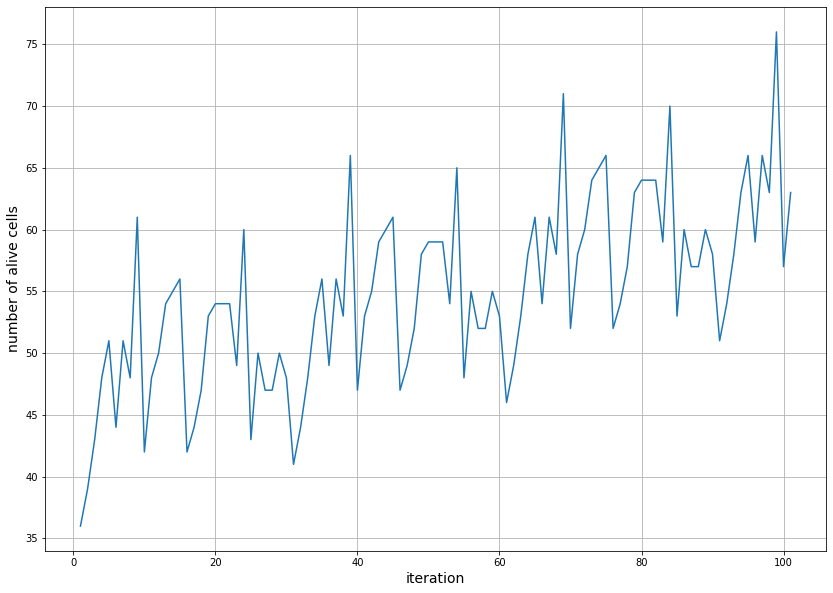

In [171]:
do_staff(gosper_init, 'gosper', save_gif=True)

In [1]:
from IPython.display import HTML
HTML('<img src="./game-gosper.gif">')

### Pulsar

100%|██████████| 101/101 [00:10<00:00,  9.65it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

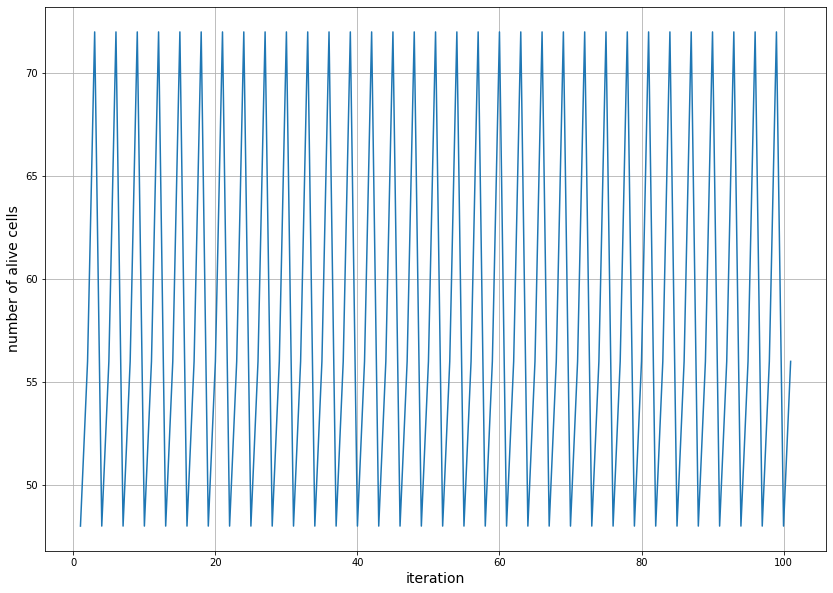

In [172]:
do_staff(pulsar_init, 'pulsar', save_gif=True)

In [2]:
from IPython.display import HTML
HTML('<img src="./game-pulsar.gif">')

### Random Sparse

100%|██████████| 101/101 [00:10<00:00,  9.23it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

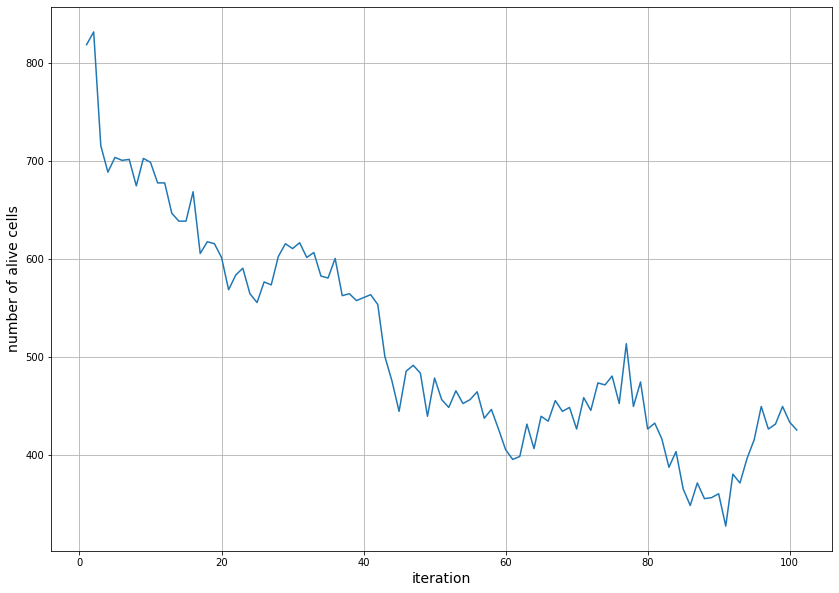

In [173]:
do_staff(random_init, 'random', save_gif=True)

In [3]:
from IPython.display import HTML
HTML('<img src="./game-random.gif">')

# Implement Parallel Game of Life using `mpi4py`

In [195]:
%%writefile solution-lab-9.py

from mpi4py import MPI

import numpy as np
import pickle
import imageio
import sys
import math

from scipy.sparse import rand
from scipy.signal import convolve2d
from mpi4py import MPI
from tqdm import tqdm

### setup mpi environment

comm = MPI.COMM_WORLD
start = MPI.Wtime()

rank = comm.Get_rank()
size = comm.Get_size()
root = 0

### define parameters for modeling

n_steps = 100 if len(sys.argv) < 2 else int(sys.argv[1])

part_up = (rank - 1) % size
part_down = (rank + 1) % size
kernel = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
]).astype(np.float32)

if rank == root:
    random_init = rand(64, 64, density=0.2, format='csr')
    random_init.data[:] = 1

    random_init = random_init.todense()

    height = random_init.shape[0]
    step = height / size

    world_stacked = [random_init[int(r * step): int((r + 1) * step)] for r in range(size)]
else:
    world_stacked = None

### assign modeling parts between processes

world_part = comm.scatter(world_stacked, root=root)

### perform modeling in every process

world_history = np.empty((n_steps + 1, *world_part.shape), dtype=np.float32)
alive_history = np.empty(n_steps + 1, dtype=np.uint8)

world_history[0] = world_part
alive_history[0] = np.sum(world_part)

for i in range(n_steps):
    world_part_updated = np.pad(world_part, 1, 'wrap')

    top_row = world_part_updated[1]
    bottom_row = world_part_updated[-2]

    comm.Isend(top_row, dest=part_up)
    comm.Irecv(world_part_updated[-1], source=part_down).wait()

    comm.Isend(bottom_row, dest=part_down)
    comm.Irecv(world_part_updated[0], source=part_up).wait()

    world_part_updated = convolve2d(world_part_updated, kernel, mode='valid')
    world_part_updated = np.where((world_part_updated == 3) | ((world_part_updated == 2) & (world_part_updated == 1)), 1., 0.)
    
    world_history[i + 1] = world_part_updated
    alive_history[i + 1] = np.sum(world_part_updated)

if rank == root:
    world_buffer = np.empty((size, n_steps + 1, math.ceil(step), world_part_updated.shape[1]), dtype=np.float32)
    alive_buffer = np.empty((size, n_steps + 1), dtype=np.uint8)
else:
    world_buffer = None
    alive_buffer = None

### collect results of modeling

comm.Gatherv(world_history, world_buffer, root)
comm.Gatherv(alive_history, alive_buffer, root)

end = MPI.Wtime()

if rank == root:
    world_buffer = np.concatenate(list(world_buffer), axis=1)
    alive_buffer = np.sum(alive_buffer, axis=0)

    with open(f'world-history-{size}.pkl', 'wb') as f:
        pickle.dump(world_buffer, f)

    with open(f'alive-history-{size}.pkl', 'wb') as f:
        pickle.dump(alive_buffer, f)
    
    with open(f'time-{size}.pkl', 'wb') as f:
        pickle.dump(end - start, f)

Overwriting solution-lab-9.py


In [199]:
nn = np.logspace(0, 3, base=2, num=4).astype(np.int)
n_steps = 400

for n_processes in nn:
    !mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-9.py {n_steps}

In [200]:
time_history = []

for n_processes in nn:
    with open(f'time-{n_processes}.pkl', 'rb') as f:
        time_elapsed = pickle.load(f)
    time_history.append(time_elapsed)

speed_up = time_history[0] / np.array(time_history)

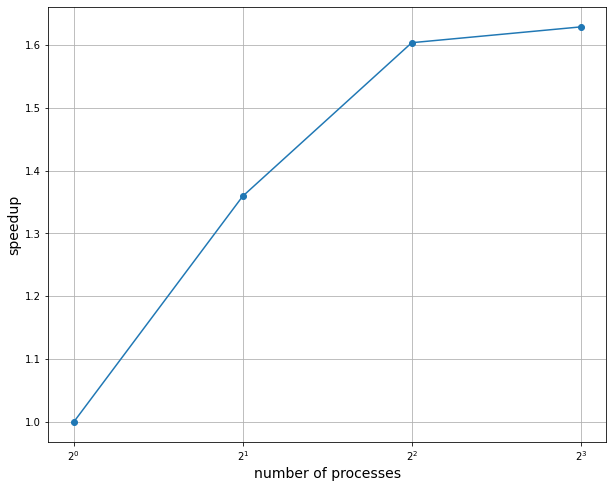

In [203]:
plt.figure(figsize=(10, 8))
plt.plot(nn, speed_up, '-o', alpha=2.)

plt.xlabel('number of processes', fontsize=14)
plt.ylabel('speedup', fontsize=14)

plt.xscale('log', basex=2)
plt.grid()
plt.show()